# NORBU Competitors Analysis - Users Review Analysis

## Competitors

https://lojongapp.com/<br>
https://meditopia.com/<br>

## Plan

1. Scrape reviews from Google play for Norbu and the competitors.
2. Explore the data.
3. Normalize the text: Remove signs like ,.: and convert to lowercase.
4. Text preprocessing: Tokenize the text and lemmatize
5. Embedding: creating bag of words, turning text into matrix of words and n-grams using TF-IDF
6. Examine the most important words and n-grams for positive reviews (4-5) and negative reviews (1-3)
7. Sentiment analysis: Predict the score and look at feature importance to understand important words and n-grams 

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from google_play_scraper import app, Sort, reviews_all
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.utils import resample
from sklearn.utils import shuffle

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap


#Error ignore
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Functions

In [ ]:
# input the data, the function will remove any signs like ,.:!? , convert to lowercase, tokenize and lemmatize the text.
# the function will return a clean DataFrame.
#this function initiates another function called text_preprocessing.

def nlp_norm (data):
    pattern = r"[^a-zA-Z']"
    #Create new column with only words and ' sign, remove all others as !, #,$, etc.
    #re.sub - Return the string obtained by replacing the leftmost non-overlapping occurrences
    #of pattern in string by the replacement repl. 
    #If the pattern isn’t found, string is returned unchanged
    data['content_clean'] = data['content'].apply(lambda x: re.sub(pattern, " ", x))
    #Remove whitespaces
    data['content_clean'] = data['content_clean'].apply(lambda x: x.strip())
    #Set all wrods to lowercase
    data['content_clean'] = data['content_clean'].apply(lambda x: x.lower())
    
    #Using spacy for tokenization and lemmatization on train data
    lemmas_review = data['content_clean'].apply(lambda x: text_preprocessing(x))
    return pd.DataFrame(lemmas_review, columns=['content_clean'])

In [ ]:
#Function for Tokanization and lemmatization. Input the text (row) and return clean text.
def text_preprocessing(text):
    
    words = nltk.word_tokenize(text)
    lemmas = ' '.join([wordnet_lemma.lemmatize(w, pos = 'n') for w in words])
    return lemmas

In [187]:
#Input the data and the target score, the function will Embed the text into matrix using TF-IDF and show 10 first most
#importnat words.
def rev_by_score_tfidf_binary (data, score):
    tf_idf = count_tf_idf.fit_transform(data[data['binary_score']==score]['content_clean'])
    tf_idf_array = tf_idf.toarray()
    bow_matrix = pd.DataFrame(data=tf_idf_array, columns=count_tf_idf.get_feature_names())
    print(bow_matrix.sum(axis=0).sort_values(ascending=False).head(10))
    
    return bow_matrix.sum(axis=0).sort_values(ascending=False).head(10)

In [184]:
#input data, the function will split it to train and test set, upsample the minority class of training set, embed the words
# and run Random Forest to predict the score.
def predict (data):
    
    target = data['binary_score']
    features = data['content_clean']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    fig, axs = plt.subplots(figsize=(10, 5))
    plt.title('Target distribution', size=15)
    sns.kdeplot(data=y_train, ax=axs, color='blue', label='Train')
    sns.kdeplot(data=y_test, ax=axs, color='green', label='Test')
    plt.legend()
    plt.show()
    
    #upsampling
    #Compbine training features and target for upsampling
    train = pd.DataFrame(X_train).merge(pd.DataFrame(y_train), left_index=True, right_index=True)
    #Divide the samples into
    bad = train[train['binary_score'] == 0]
    good = train[train['binary_score'] == 1]
    #Upsample of minority
    bad_upsample = resample(bad, replace=True, n_samples = len(good)-len(bad), random_state=42)
    
    upsampled = pd.concat([good,bad,bad_upsample])
    upsampled = shuffle(upsampled, random_state=42)
    print('New sample:',upsampled['binary_score'].value_counts())
    
    X_train = upsampled.drop(['binary_score'], axis=1)
    y_train = upsampled['binary_score']
    
    fig, axs = plt.subplots(figsize=(10, 5))
    plt.title('Target distribution after upsampling', size=15)
    sns.kdeplot(data=y_train, ax=axs, color='blue', label='Train')
    sns.kdeplot(data=y_test, ax=axs, color='green', label='Test')
    plt.legend()
    plt.show()
    

    train_features = count_tf_idf.fit_transform(X_train.squeeze())
    test_features = count_tf_idf.transform(X_test)

    RandomForest = RandomForestClassifier(random_state=42).fit(train_features, y_train)
    scores_rf = cross_validate(RandomForest, train_features, y_train, cv=5,scoring='f1')
    print('F1 score:',scores_rf['test_score'].mean())

    y_pred_rf = RandomForest.predict(test_features)

    conf_rf = confusion_matrix(y_test, y_pred_rf)

    ax = sns.heatmap(conf_rf, annot=True, cmap='Blues',fmt='g')
    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels([0,1])
    ax.set_yticklabels([0,1])
    plt.show()
    
    tf_idf_array = train_features.toarray()
    bow_matrix = pd.DataFrame(data=tf_idf_array, columns=count_tf_idf.get_feature_names())

    plt.barh(bow_matrix.columns[np.argsort(np.sort(RandomForest.feature_importances_)[::-1][:10])], np.sort(RandomForest.feature_importances_)[::-1][:10])
    plt.title('Binary class classification features importance', size=15)
    plt.show()

    print(classification_report(y_test, y_pred_rf))
    

## Scrapping

In [2]:
#Google configuration
norbu_google_users_rev = reviews_all('app.norbu', sleep_milliseconds=0)

In [3]:
#Convert to DataFrame
df_norbu_google_users_rev = pd.DataFrame(np.array(norbu_google_users_rev), columns=['reviews'])

In [4]:
df_norbu_google_users_rev = df_norbu_google_users_rev.join(pd.DataFrame(df_norbu_google_users_rev.pop('reviews').tolist()))

## EDA

In [5]:
df_norbu_google_users_rev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOFSKOAazQ2FFZ2vFr-TcBjTogY-nPYegeujMna...,hastii 21,https://play-lh.googleusercontent.com/a/AATXAJ...,برنامه ی خیلی خوبیه، ولی چرا برای بقیه همه چیش...,4,0,3.5.2,2022-03-11 11:05:50,None,NaT
1,gp:AOqpTOEIDE2MAUa-wpGbWbf8fVslNSBqb27v55AeE70...,Anurag Sengupta,https://play-lh.googleusercontent.com/a/AATXAJ...,Hi I cancelled the subscription two days befor...,1,1,3.5.1,2022-03-04 22:49:52,None,NaT
2,gp:AOqpTOE0dnRGUOJ1vu3WgrjB7X3L72pxSCkjJZNpY1D...,Prakhar Dubey,https://play-lh.googleusercontent.com/a-/AOh14...,Just spent your money away😡,1,0,None,2022-01-31 15:51:19,Sorry to hear. Could you please explain what's...,2022-01-31 16:00:20
3,gp:AOqpTOG34YKH-ayEjmSJlLSJoLpcxzug-OOJkr3jOqN...,Ghazal mhmdi,https://play-lh.googleusercontent.com/a/AATXAJ...,I liked him♥️,5,0,None,2022-01-27 17:56:01,"Dear friend, we are really glad that you like ...",2022-01-31 18:07:02
4,gp:AOqpTOEb0IhZUxJd5duUIlKqbXSwgvTQ2hIEWVjUVX_...,Atena Amini,https://play-lh.googleusercontent.com/a-/AOh14...,It didn't work after a week:(,3,0,None,2022-01-27 13:56:40,"Hello, did your problem get resolved? If not, ...",2022-01-31 18:01:45


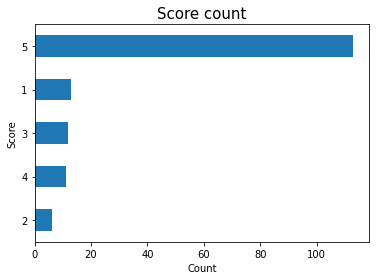

In [6]:
df_norbu_google_users_rev['score'].value_counts().sort_values().plot(kind='barh')
plt.title('Score count', size=15)
plt.ylabel('Score')
plt.xlabel('Count')
plt.show()

In [87]:
df_norbu_google_users_rev['score'].value_counts()

5    103
1     12
3     10
4     10
2      5
Name: score, dtype: int64

We have small number of revies, total of 155, while most of them good reviews scored with 5 (103), followed by the worst score of 1 (12)

In [7]:
df_norbu_google_users_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              155 non-null    object        
 1   userName              155 non-null    object        
 2   userImage             155 non-null    object        
 3   content               155 non-null    object        
 4   score                 155 non-null    int64         
 5   thumbsUpCount         155 non-null    int64         
 6   reviewCreatedVersion  109 non-null    object        
 7   at                    155 non-null    datetime64[ns]
 8   replyContent          150 non-null    object        
 9   repliedAt             150 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 12.2+ KB


In [8]:
df_norbu_google_users_rev['at'].describe(datetime_is_numeric=True)E

count                              155
mean     2021-03-10 19:34:02.625806592
min                2020-02-09 23:19:13
25%                2020-11-08 13:57:02
50%                2020-12-13 11:02:02
75%         2021-10-01 13:51:00.500000
max                2022-03-11 11:05:50
Name: at, dtype: object

There are 155 reviews from 2020 to 2022.

In [9]:
df_norbu_google_users_rev['date'] = df_norbu_google_users_rev['at'].dt.date

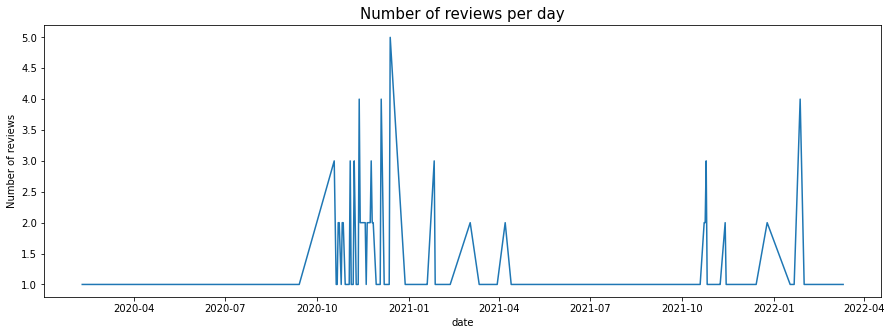

In [10]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_norbu_google_users_rev.groupby('date')['content'].count(), ax=axs)
plt.title('Number of reviews per day', size=15)
plt.ylabel('Number of reviews')
plt.show()

Most of the days there only 1 review per day, in the period starting from Oct 2020 to Apr 2021 there was more activity with more than 1 review per day. Also we see some increase in activity from Oct 2021 until Apr 2022.

## Normalization

In [132]:
wordnet_lemma = WordNetLemmatizer()

In [ ]:
#We will look for words and n-gram up to 3 words
count_tf_idf = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,3))

In [133]:
data_norbu = nlp_norm(df_norbu_google_users_rev)
data_norbu.head()

,content_clean
1,hi i cancelled the subscription two day before my trial ended and yet i wa charged please see to it and refund me the same a i do n't have any usage of the app for me at this moment of time
2,just spent your money away
3,i liked him
4,it did n't work after a week
5,that 's great


In [134]:
#Merge with score
data_norbu = data_norbu.merge(df_norbu_google_users_rev['score'],left_index=True, right_index=True)
data_norbu.head()

,content_clean,score
1,hi i cancelled the subscription two day before my trial ended and yet i wa charged please see to it and refund me the same a i do n't have any usage of the app for me at this moment of time,1
2,just spent your money away,1
3,i liked him,5
4,it did n't work after a week,3
5,that 's great,5


In [135]:
#Add binary score
data_norbu['binary_score'] = [1 if i > 3 else 0 for i in data_norbu['score']]
data_norbu.head()

,content_clean,score,binary_score
1,hi i cancelled the subscription two day before my trial ended and yet i wa charged please see to it and refund me the same a i do n't have any usage of the app for me at this moment of time,1,0
2,just spent your money away,1,0
3,i liked him,5,1
4,it did n't work after a week,3,0
5,that 's great,5,1


### Score 0

In [210]:
text_0_norbu = rev_by_score_tfidf_binary (data_norbu, 0)

app         1.372388
paywall     1.000000
free        0.963974
work        0.901314
ever        0.866160
worst       0.866160
game        0.745642
good        0.726840
nice app    0.657800
nice        0.657800
dtype: float64


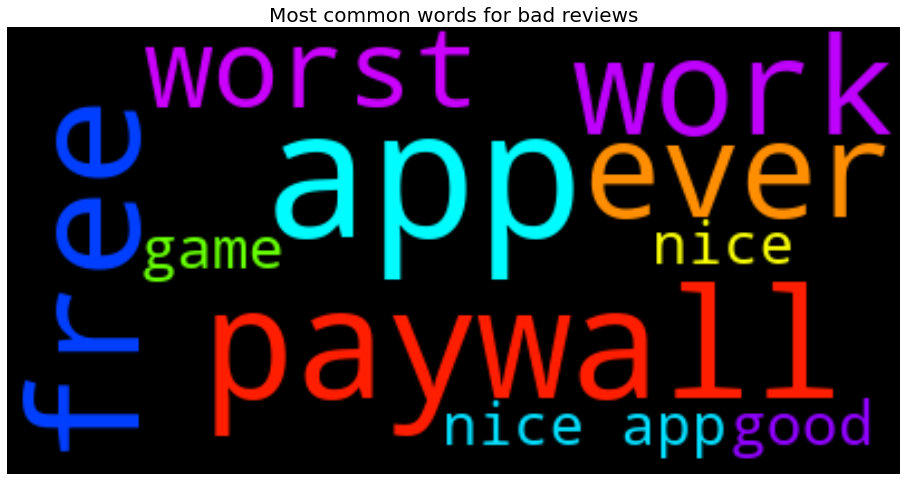

In [207]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(text_0_norbu)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words for bad reviews', size=20)
plt.show()

### Score 1

In [191]:
text_1_norbu = rev_by_score_tfidf_binary (data_norbu, 1)

good         7.695621
app          5.564861
excellent    5.108707
great        3.797742
love         3.400858
nice         3.093284
stress       2.525008
best         2.452400
helpful      2.231384
work         2.150978
dtype: float64


In [27]:
pd.options.display.max_colwidth = 400

In [217]:
#Look for negative text
data_norbu[data_norbu['binary_score']==0].loc[data_norbu['content_clean'].str.contains("game", case=False)]['content_clean']

26                                                                                                                                          sadly this did n't help me if anything the neuron massage game stressed me out more breathing exercise can be good however i find calming distraction or peaceful game better for my daily attack overall it a good app but just caused more anxiety and stress for myself
65     i just downloaded it it might be a good game but the english in this game is rather odd and i am not sure if i answered the question accurately because i am not sure if i understood them a the writer intended in the result page i had some trouble understanding the category because i knew all the word i just wa not sure what they meant in context this stressed me out and made me feel axious so ...
86                                                                                                                                                                                        

## Conclusion

Seems that people don't like the balls game, its moves to fast and not relaxing at all, rules are not clear.

# Prediction and feature importnace

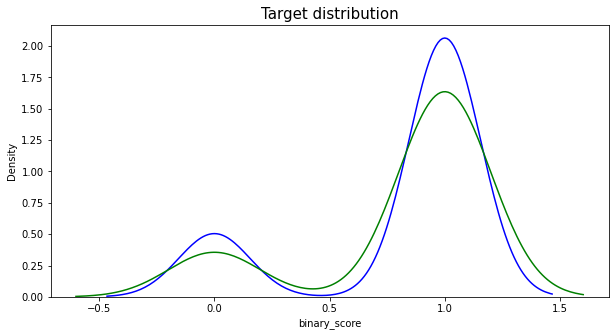

New sample: 1    90
0    90
Name: binary_score, dtype: int64


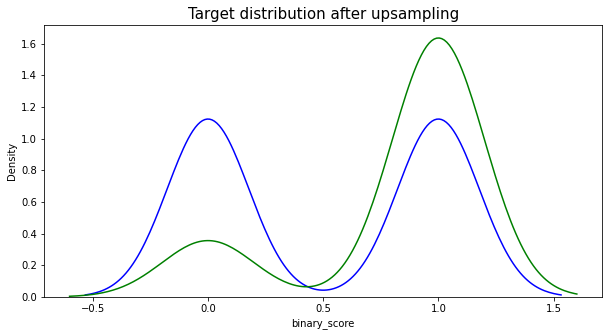

F1 score: 0.9581573476310318


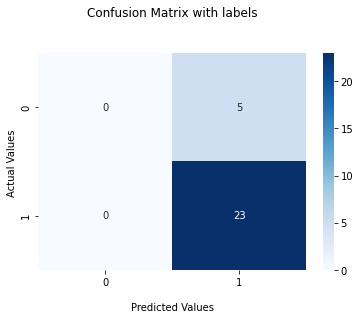

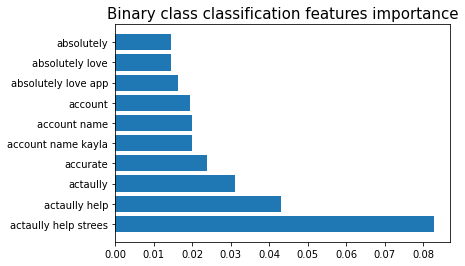

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.82      1.00      0.90        23

    accuracy                           0.82        28
   macro avg       0.41      0.50      0.45        28
weighted avg       0.67      0.82      0.74        28



(RandomForestClassifier(random_state=42),
      absolutely  absolutely love  absolutely love app  account  account name  \
 0           0.0              0.0                  0.0      0.0           0.0   
 1           0.0              0.0                  0.0      0.0           0.0   
 2           0.0              0.0                  0.0      0.0           0.0   
 3           0.0              0.0                  0.0      0.0           0.0   
 4           0.0              0.0                  0.0      0.0           0.0   
 ..          ...              ...                  ...      ...           ...   
 175         0.0              0.0                  0.0      0.0           0.0   
 176         0.0              0.0                  0.0      0.0           0.0   
 177         0.0              0.0                  0.0      0.0           0.0   
 178         0.0              0.0                  0.0      0.0           0.0   
 179         0.0              0.0                  0.0      0.0    

In [142]:
predict(data_norbu)

# Meditation: Lojong

In [50]:
#Google configuration
lojong_google_users_rev = reviews_all('br.com.lojong', sleep_milliseconds=0)
#Convert to DataFrame
df_lojong_google_users_rev = pd.DataFrame(np.array(lojong_google_users_rev), columns=['reviews'])
df_lojong_google_users_rev = df_lojong_google_users_rev.join(pd.DataFrame(df_lojong_google_users_rev.pop('reviews').tolist()))

df_lojong_google_users_rev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHDrEZs6IdK_KwXcYmBnY1t4SSQBin9rkK1GO1UGdHcCkNA-Gh80rsIi-tzroaZ4Bpdx-bwquoBIuG7wA,Mimi’s World of YouTube,https://play-lh.googleusercontent.com/a-/AOh14GhR_-20r9bTu5B3R03q1-UrEfxG7i8KSzEFC8wu,"It's okay, but some of the instructors don't sound calm and the meditations are boring",2,0,None,2022-04-10 07:59:24,None,NaT
1,gp:AOqpTOGpg-JEGcaRaLfaMeDukOfDVafBt3UOBCPt_CdaMrpuyWTYrIj9wqo-erROQoUKHf72qkEgEluQOl5b-g,Ashley Odonnell,https://play-lh.googleusercontent.com/a-/AOh14GjuCMamyU2JteeZ4bi0G_F0WdnLAexyOKvy_F1asQ,I'm confused because I bought the premium because I liked the free version so much but now it says my subscription is active but it won't let me play premium stuff. I tried going to help and relaunching premium but it's not working....,3,0,2.26.4,2022-04-08 17:49:26,"Good afternoon, Ashley! We apologize for this situation! Please, follow these steps to update the app and check if the problem is solved: go to ""More"", ""Settings"", ""Language"", ""English"", ""Yes"" and wait for the system to update. If the problem remains, please, send us an email at contact@lojongapp.com. Best regards from the Lojong Team! 🤗❤️",2022-04-08 18:13:19
2,gp:AOqpTOFwyRuQ1Lr-0RpQy0F-urTSASYbk8-_5AdciboCbD3rlANLWeAhq0ndc3k6sZOHjMWppSdRIsdbKG4B_Q,Julia Riell,https://play-lh.googleusercontent.com/a-/AOh14Gjp9aQMm3ZgByITQZ2HAK5k9lTb9WYUjWh4_jey6Q,"Start. Right here. I have pursued/practised meditation and yoga on and off for years. This put me on a solid path to center this practice in my life. Used originally to unf*ck my mind regarding quitting smoking, and staying quit, now I am grateful truly grateful for this app. Even the adverts (which only come at the beginning, never during practice) are for things that I am interested in. I wi...",5,0,2.25.6,2022-04-08 15:46:45,"Good afternoon, Julia! It's amazing to receive your feedback! Our goal is to make meditation more accessible and inclusive for everyone! Best regards from the Lojong Team. 🤗❤️",2022-04-08 18:56:54
3,gp:AOqpTOGwzQcVY7xeMOMWxGzqF2wDhqYDJWVfxcQ_5AqdEHBEyvayRlhs2jqZEoOWUHtYnrunNBOIotI6oJXlmg,Malgorzata,https://play-lh.googleusercontent.com/a-/AOh14GjGNSDQc93twkwq73ZU3kKPpbJBlXLfTlh-uYQFng,"I've tried different meditation apps before but this one is easily the best. It's easy to use and offers a lot of insight into different types of meditation. While I learn about it in the beginner course, I also keep coming back to guided relaxations and sleep meditation playlist, they're both incredibly helpful. I really appreciate being able to select different voice guides, it allows for cu...",5,0,2.26.2,2022-04-08 01:13:18,We are very happy with your feedback! We are always looking to improve the app! Best regards from the Lojong Team. 🤗❤️\n,2022-04-08 18:52:37
4,gp:AOqpTOG5FRZGBv6qNUaEi_fdEUC4aarsB6wks5HhHs6SCKGKUHZ8TxaicroDaS2u_maryR4ppiy6rlMv5ARc3A,juan carlos muñoz,https://play-lh.googleusercontent.com/a-/AOh14Gj7gOQFaUHHm-kmAZyCvsTLNcbS3ErDj28H0YZX,"Me ayudó muchísimo, espero sigan creciendo",5,0,2.26.2,2022-04-07 08:06:42,"Hola, Juan Carlos. ¡Gracias por tu valoración! Nuestras prácticas tienen como objetivo promover el bienestar de los usuarios y usuarias, ayudándoles a desarrollar la calma y la tranquilidad para hacer frente a las situaciones que surgen en el día a día. Un gran abrazo del equipo de Lojong. 🤗❤️\n",2022-04-07 23:29:59


In [51]:
df_lojong_google_users_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1851 non-null   object        
 1   userName              1851 non-null   object        
 2   userImage             1851 non-null   object        
 3   content               1851 non-null   object        
 4   score                 1851 non-null   int64         
 5   thumbsUpCount         1851 non-null   int64         
 6   reviewCreatedVersion  1756 non-null   object        
 7   at                    1851 non-null   datetime64[ns]
 8   replyContent          1422 non-null   object        
 9   repliedAt             1422 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 144.7+ KB


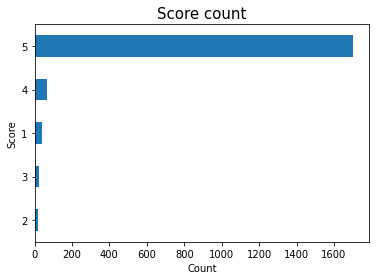

In [52]:
df_lojong_google_users_rev['score'].value_counts().sort_values().plot(kind='barh')
plt.title('Score count', size=15)
plt.ylabel('Score')
plt.xlabel('Count')
plt.show()

In [143]:
df_lojong_google_users_rev['score'].value_counts()

5    1704
4      64
1      42
3      24
2      17
Name: score, dtype: int64

Most of the scores are 5 (1,704 reviews), followed by 4 (64 reviews)

In [53]:
df_lojong_google_users_rev['at'].describe(datetime_is_numeric=True)

count                             1851
mean     2021-01-19 19:27:57.446245376
min                2017-12-25 19:18:56
25%                2020-07-30 22:34:52
50%                2021-05-28 05:42:56
75%         2021-08-21 08:06:14.500000
max                2022-04-10 07:59:24
Name: at, dtype: object

We have reviews from Dec 2017 until today (Apr 2022)

In [54]:
df_lojong_google_users_rev['date'] = df_lojong_google_users_rev['at'].dt.date

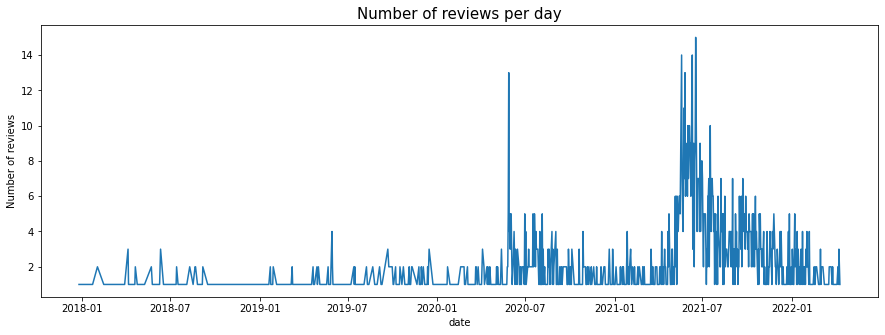

In [55]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_lojong_google_users_rev.groupby('date')['content'].count(), ax=axs)
plt.title('Number of reviews per day', size=15)
plt.ylabel('Number of reviews')
plt.show()

we have peak of reviews in July 2020 and then again on July 2021 and reducing.

## Normalization

1. Remove all signs
2. Tokenize
3. Lemmatize
4. Join
5. TF-IDF
6. Predict

In [60]:
data_lojong = nlp_norm(df_lojong_google_users_rev)
data_lojong.head()

,content_clean
0,it 's okay but some of the instructor do n't sound calm and the meditation are boring
1,i 'm confused because i bought the premium because i liked the free version so much but now it say my subscription is active but it wo n't let me play premium stuff i tried going to help and relaunching premium but it 's not working
2,start right here i have pursued practised meditation and yoga on and off for year this put me on a solid path to center this practice in my life used originally to unf ck my mind regarding quitting smoking and staying quit now i am grateful truly grateful for this app even the advert which only come at the beginning never during practice are for thing that i am interested in i will most likely...
3,i 've tried different meditation apps before but this one is easily the best it 's easy to use and offer a lot of insight into different type of meditation while i learn about it in the beginner course i also keep coming back to guided relaxation and sleep meditation playlist they 're both incredibly helpful i really appreciate being able to select different voice guide it allows for curating ...
4,me ayud much simo espero sigan creciendo


In [61]:
data_lojong = data_lojong.merge(df_lojong_google_users_rev['score'],left_index=True, right_index=True)
data_lojong

,content_clean,score
0,it 's okay but some of the instructor do n't sound calm and the meditation are boring,2
1,i 'm confused because i bought the premium because i liked the free version so much but now it say my subscription is active but it wo n't let me play premium stuff i tried going to help and relaunching premium but it 's not working,3
2,start right here i have pursued practised meditation and yoga on and off for year this put me on a solid path to center this practice in my life used originally to unf ck my mind regarding quitting smoking and staying quit now i am grateful truly grateful for this app even the advert which only come at the beginning never during practice are for thing that i am interested in i will most likely...,5
3,i 've tried different meditation apps before but this one is easily the best it 's easy to use and offer a lot of insight into different type of meditation while i learn about it in the beginner course i also keep coming back to guided relaxation and sleep meditation playlist they 're both incredibly helpful i really appreciate being able to select different voice guide it allows for curating ...,5
4,me ayud much simo espero sigan creciendo,5
...,...,...
1846,amei este app esta de parabens otima experiencia,5
1847,maravilhoso,5
1848,maravilhoso estou me sentindo completamente relaxado e em paz,5
1849,terminei a sess o ma ele n o contabilizou,2


In [62]:
data_lojong['binary_score'] = [1 if i > 3 else 0 for i in data_lojong['score']]
data_lojong.head()

,content_clean,score,binary_score
0,it 's okay but some of the instructor do n't sound calm and the meditation are boring,2,0
1,i 'm confused because i bought the premium because i liked the free version so much but now it say my subscription is active but it wo n't let me play premium stuff i tried going to help and relaunching premium but it 's not working,3,0
2,start right here i have pursued practised meditation and yoga on and off for year this put me on a solid path to center this practice in my life used originally to unf ck my mind regarding quitting smoking and staying quit now i am grateful truly grateful for this app even the advert which only come at the beginning never during practice are for thing that i am interested in i will most likely...,5,1
3,i 've tried different meditation apps before but this one is easily the best it 's easy to use and offer a lot of insight into different type of meditation while i learn about it in the beginner course i also keep coming back to guided relaxation and sleep meditation playlist they 're both incredibly helpful i really appreciate being able to select different voice guide it allows for curating ...,5,1
4,me ayud much simo espero sigan creciendo,5,1


## Score 0

In [192]:
text_0_lojong = rev_by_score_tfidf_binary (data_lojong, 0)

english       3.741499
app           2.980571
spanish       2.201520
meditation    1.837703
ad            1.457094
de            1.297911
premium       1.263376
wa            1.192714
language      1.111497
awful         1.073840
dtype: float64


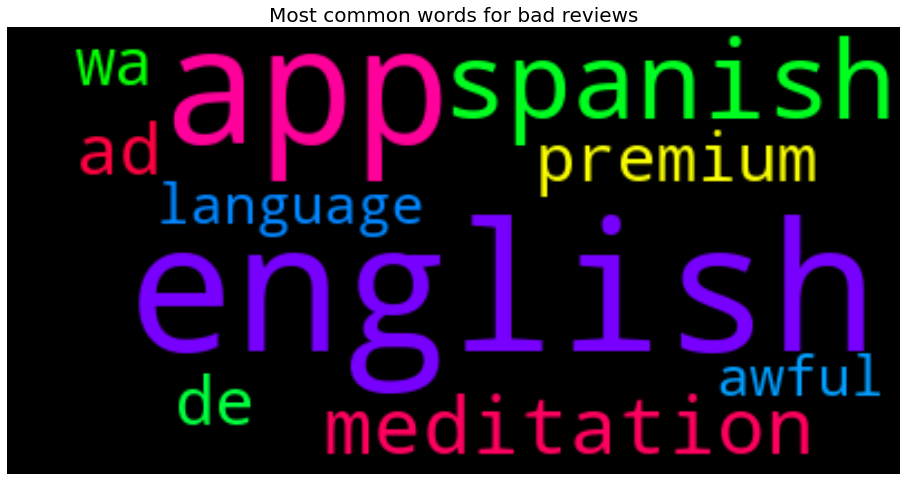

In [206]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(text_0_lojong)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words for bad reviews', size=20)
plt.show()

## Score 1

In [193]:
text_1_lojong = rev_by_score_tfidf_binary (data_lojong, 1)

app            64.200192
great          37.405758
good           36.675782
love           36.360487
amazing        31.667181
excelente      29.270422
meditation     28.178334
muito          27.819671
best           24.883512
maravilhoso    21.575915
dtype: float64


## See text

In [149]:
data_lojong[data_lojong['binary_score']==0].loc[data_lojong['content_clean'].str.contains("english", case=False)]['content_clean']

371                                                                                                                                 where is english
409                                                                                                                             it 's not in english
430                                                                                                                             it 's not in english
471     my app is only in spanish and i ca n't find a way to change language to english sadly i had to uninstall and find a different meditation app
1026                                                                                            how to we change the language english into malayalam
1448                                                            i always meditate in english but there 's only portuguese or spanish language option
1687                                                                       no language selection i speak e

## Conclusion

Many users complain about no English in this app, only Spanish. the also forces you to watch ads before each session, and users find it very anoying.

## Prediction

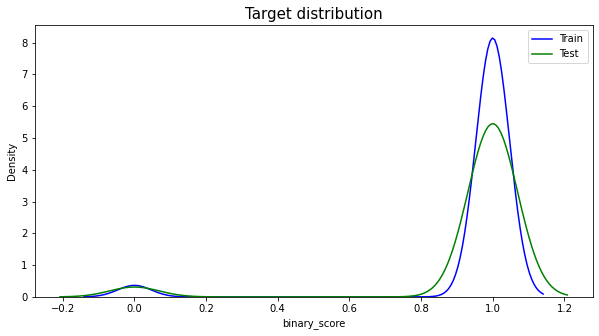

New sample: 1    1417
0    1417
Name: binary_score, dtype: int64


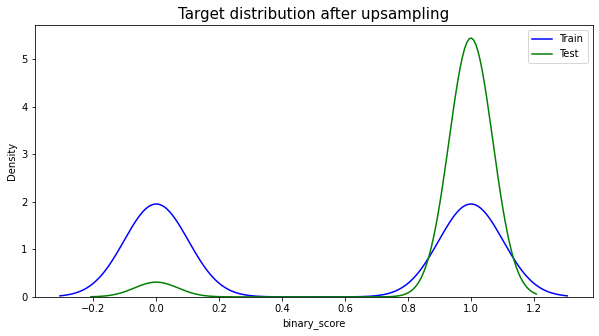

F1 score: 1.0


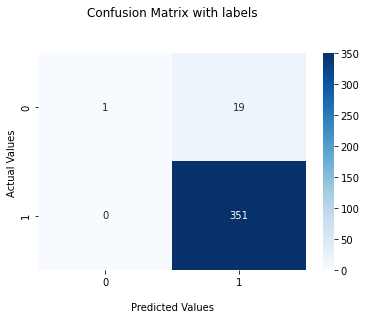

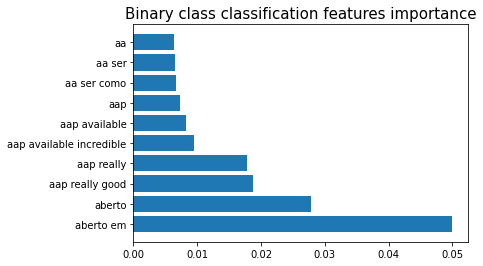

              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.95      1.00      0.97       351

    accuracy                           0.95       371
   macro avg       0.97      0.53      0.53       371
weighted avg       0.95      0.95      0.93       371



(RandomForestClassifier(random_state=42),
        aa  aa ser  aa ser como  aap  aap available  aap available incredible  \
 0     0.0     0.0          0.0  0.0            0.0                       0.0   
 1     0.0     0.0          0.0  0.0            0.0                       0.0   
 2     0.0     0.0          0.0  0.0            0.0                       0.0   
 3     0.0     0.0          0.0  0.0            0.0                       0.0   
 4     0.0     0.0          0.0  0.0            0.0                       0.0   
 ...   ...     ...          ...  ...            ...                       ...   
 2829  0.0     0.0          0.0  0.0            0.0                       0.0   
 2830  0.0     0.0          0.0  0.0            0.0                       0.0   
 2831  0.0     0.0          0.0  0.0            0.0                       0.0   
 2832  0.0     0.0          0.0  0.0            0.0                       0.0   
 2833  0.0     0.0          0.0  0.0            0.0                

In [152]:
predict(data_lojong)

# Meditopia

In [70]:
#Google configuration
meditopia_google_users_rev = reviews_all('app.meditasyon', sleep_milliseconds=0)
#Convert to DataFrame
df_meditopia_google_users_rev = pd.DataFrame(np.array(meditopia_google_users_rev), columns=['reviews'])
df_meditopia_google_users_rev = df_meditopia_google_users_rev.join(pd.DataFrame(df_meditopia_google_users_rev.pop('reviews').tolist()))

df_meditopia_google_users_rev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHruZY1zpYMPQlfp3YCEMDncFxTTgBIqEgjdVLidpmJ48mzAYqgbqFw5cCZUyu258mZRcIwrWLRtW5m-10,Nina Van Medegael,https://play-lh.googleusercontent.com/a-/AOh14GhFD88QaNzfX-lwFyqsR9NW_HStM1eFHb3t4CwbLw,I always use one meditation to sleep but the rest is bot really helpfull to be honest and more then the half is to buy please make more stuff free then i would use it more,2,0,None,2022-04-08 10:09:37,"Hello Nina! It's wonderful to hear that our meditations accompany you to sleep. You can always try our Premium sleep content; we offer a free trial period for our members to explore the meditations beforehand. Hope you have wonderful meditations with us! All the best, Irmak - Member Happiness",2022-04-08 12:35:02
1,gp:AOqpTOGN3fpyQwv7IPyaJsg3QxxNj8lzosRbTUb_iWEh6D-qKTAkoedfc5C4eM9qtXstMDiTRF94rkCeZOXv8cw,Manfrin Pool Antialon,https://play-lh.googleusercontent.com/a-/AOh14GguiTl6sz-dNI7pII8X3MEWAn_Iff8Vzg9zuilLvg,"I just updated the app and I can't run it cause I get a message saying ""there a problem, try again."" I hope you solve this problem quickly cause I payed for the annual membership and now I can't even listening any meditation.",1,0,3.23.2,2022-04-07 22:27:58,"Hello! It would help to have at least 2 GB of free space on your device for optimal use. You can also make sure to enter the app with the address enlisted in your Premium account. If the issue persists afterwards, please reach out to us at hello@meditopia.com so we can look into it in detail. All the best, Irmak - Member Happiness",2022-04-08 12:28:34
2,gp:AOqpTOFXe8PadbMbg1rfBxOGBSCeEFNxB6__90fYlq0ioEJxZcTQzg8FKEZneMF0xy1Tvh7aIaU_jI7NZ7GeiKs,jean forichon,https://play-lh.googleusercontent.com/a-/AOh14GhzPQTN6jKS1_UUJdSq1kPa89oSg1HXdl6QA9zR8Q,I am not going to pay annually.....Let rhe users pay on a month basis.....,3,0,3.22.1,2022-04-06 14:29:41,"Hello Jean, we have both monthly and annual plans for Premium membership besides another version of completely free membership. If you need help in navigating through subscription plans, reach us via hello@meditopia.com We are waiting to hear from you! All the best, İpek - Member Happiness",2022-04-06 15:28:24
3,gp:AOqpTOH94vdiMGIB-IchM9vbqBcwsL2JWvohPf84GhY5k5wvyCbhGsKkOpGTgaXII2xY6VLSbg8OYbcTrdvmBZg,Angie Pimentel,https://play-lh.googleusercontent.com/a-/AOh14GhllyUQFmqq1lsi7RLz2nBz9GxHI74CDW0IvKzj,"I really recommend this app because I had sleeping problems for a while, and since I started using it, I got the chance of feeling relaxed, therefore, getting better sleep.",5,0,3.22.1,2022-04-06 12:54:18,None,NaT
4,gp:AOqpTOGIv7rUDreo5QVSkj5zcY0B5Z37mCGquPWleGNp79bLd8K0m_vPq-Moi-ajkIm8hbL0xUbdWnaFbcx0Izo,FourBlix Test,https://play-lh.googleusercontent.com/a/AATXAJyZVTxfBeTEUg5C30sYrEAmgIklzCn1QoNfIoaV=mo,Gd,3,0,None,2022-04-06 09:53:18,None,NaT


In [71]:
df_meditopia_google_users_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 0 to 2573
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2574 non-null   object        
 1   userName              2574 non-null   object        
 2   userImage             2574 non-null   object        
 3   content               2574 non-null   object        
 4   score                 2574 non-null   int64         
 5   thumbsUpCount         2574 non-null   int64         
 6   reviewCreatedVersion  2267 non-null   object        
 7   at                    2574 non-null   datetime64[ns]
 8   replyContent          833 non-null    object        
 9   repliedAt             833 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 201.2+ KB


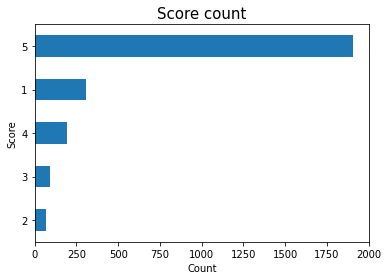

In [72]:
df_meditopia_google_users_rev['score'].value_counts().sort_values().plot(kind='barh')
plt.title('Score count', size=15)
plt.ylabel('Score')
plt.xlabel('Count')
plt.show()

In [153]:
df_meditopia_google_users_rev['score'].value_counts()

5    1908
1     310
4     196
3      91
2      69
Name: score, dtype: int64

We have many great reviews of 5 (1,908), folloed by the worst score of 1 (310 reviews)

In [73]:
df_meditopia_google_users_rev['at'].describe(datetime_is_numeric=True)

count                             2574
mean     2020-08-29 21:10:56.552059136
min                2017-03-07 21:48:30
25%                2020-03-24 02:27:13
50%         2020-08-19 09:22:19.500000
75%      2021-03-22 04:09:13.750000128
max                2022-04-08 10:09:37
Name: at, dtype: object

We have reviews starting from Mar 2017 until today (Apr 2022)

In [74]:
df_meditopia_google_users_rev['date'] = df_meditopia_google_users_rev['at'].dt.date

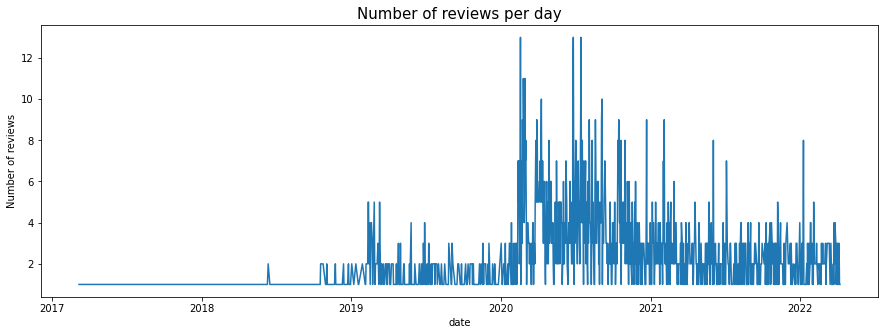

In [75]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_meditopia_google_users_rev.groupby('date')['content'].count(), ax=axs)
plt.title('Number of reviews per day', size=15)
plt.ylabel('Number of reviews')
plt.show()

We see number of reviews per day peaking around Feb 2020 and decreasing, but more than one review per day.

## Normalization

1. Remove all signs
2. Tokenize
3. Lemmatize
4. Join
5. TF-IDF
6. Predict

In [76]:
data_meditopia = nlp_norm(df_meditopia_google_users_rev)
data_meditopia = data_meditopia.merge(df_meditopia_google_users_rev['score'],left_index=True, right_index=True)
data_meditopia.head()

,content_clean,score
0,i always use one meditation to sleep but the rest is bot really helpfull to be honest and more then the half is to buy please make more stuff free then i would use it more,2
1,i just updated the app and i ca n't run it cause i get a message saying there a problem try again i hope you solve this problem quickly cause i payed for the annual membership and now i ca n't even listening any meditation,1
2,i am not going to pay annually let rhe user pay on a month basis,3
3,i really recommend this app because i had sleeping problem for a while and since i started using it i got the chance of feeling relaxed therefore getting better sleep,5
4,gd,3


In [77]:
data_meditopia['binary_score'] = [1 if i > 3 else 0 for i in data_meditopia['score']]
data_meditopia.head()

,content_clean,score,binary_score
0,i always use one meditation to sleep but the rest is bot really helpfull to be honest and more then the half is to buy please make more stuff free then i would use it more,2,0
1,i just updated the app and i ca n't run it cause i get a message saying there a problem try again i hope you solve this problem quickly cause i payed for the annual membership and now i ca n't even listening any meditation,1,0
2,i am not going to pay annually let rhe user pay on a month basis,3,0
3,i really recommend this app because i had sleeping problem for a while and since i started using it i got the chance of feeling relaxed therefore getting better sleep,5,1
4,gd,3,0


## Score 0

In [195]:
text_0_meditopia = rev_by_score_tfidf_binary (data_meditopia, 0)

free            14.331252
app             12.011455
pay             11.484169
trial            6.915481
subscription     6.025623
good             5.906455
meditation       5.604838
expensive        5.490041
wa               4.915696
even             4.647504
dtype: float64


In [196]:
text_0_meditopia

free            14.331252
app             12.011455
pay             11.484169
trial            6.915481
subscription     6.025623
good             5.906455
meditation       5.604838
expensive        5.490041
wa               4.915696
even             4.647504
dtype: float64

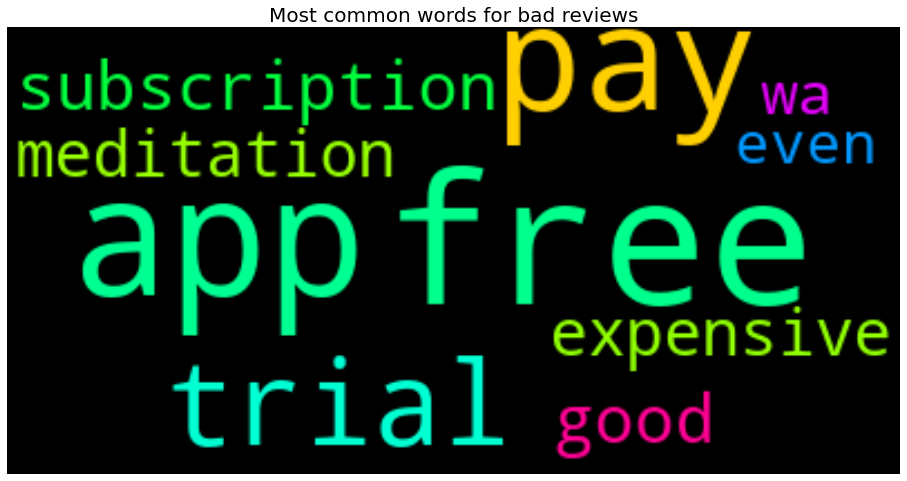

In [205]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(text_0_meditopia)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words for bad reviews', size=20)
plt.show()

## Score 1

In [194]:
text_1_meditopia = rev_by_score_tfidf_binary (data_meditopia, 1)

app           80.972509
love          79.635823
great         77.868146
good          66.348520
amazing       52.289854
relaxing      45.988042
best          34.312999
help          31.052088
meditation    28.723173
awesome       26.851198
dtype: float64


## See text

In [161]:
data_meditopia[data_meditopia['binary_score']==0].loc[data_meditopia['content_clean'].str.contains("free", case=False)]['content_clean']

0                                                                                                                                                                                                                                      i always use one meditation to sleep but the rest is bot really helpfull to be honest and more then the half is to buy please make more stuff free then i would use it more
14                                                                               i have to pay for a monthly subscription like everything else maybe if i had free thing to try out for sleeping to get an experience rather than day free then get charged monthly i wa interested then i wasted my time filling out your question just to get offered a subscription instantly deleted i 'll find something else
36                                                                                                                                                                                                

## Conclusion

Most of the content is for premium users, not enought free content. the trial is too short.

## Prediction

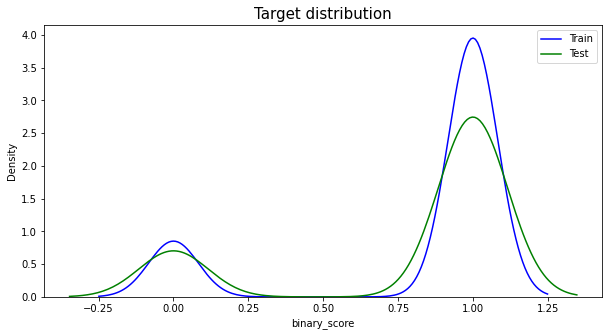

New sample: 0    1694
1    1694
Name: binary_score, dtype: int64


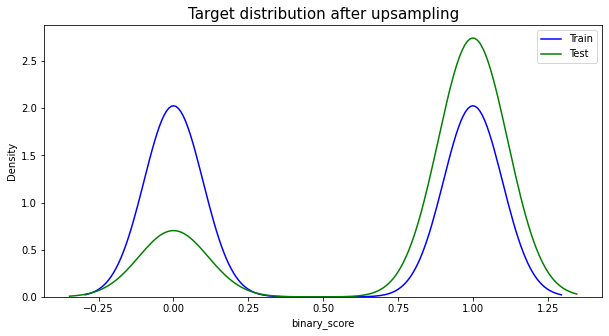

F1 score: 0.9447281033488352


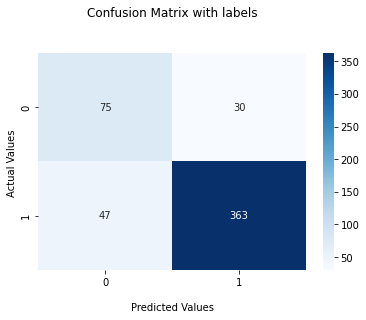

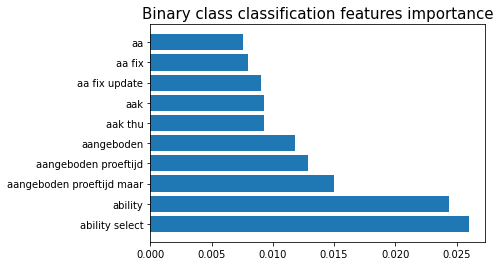

              precision    recall  f1-score   support

           0       0.61      0.71      0.66       105
           1       0.92      0.89      0.90       410

    accuracy                           0.85       515
   macro avg       0.77      0.80      0.78       515
weighted avg       0.86      0.85      0.85       515



In [186]:
predict(data_meditopia)